In [1]:
# imports
# !pip install torch 
#!pip install openpyxl

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import datetime 

In [2]:
def displayDataFrame(df_to_display, all_frame=False):
    if all_frame:
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
            display(df_to_display)
    else:
        display(df_to_display)

In [ ]:
#!gsutil cp -r gs://lead_routing_data ../
bucket_name = '~/lead_routing_data/'

In [3]:
# read data
area_codes_df = pd.read_excel('{}/areacodes.xlsx'.format(bucket_name), header=None)
displayDataFrame(area_codes_df, all_frame=False)

leads_df = pd.read_csv('{}/all_calls_2021.csv'.format(bucket_name), 
                    parse_dates=['callDate','callStartTime'])
displayDataFrame(leads_df, all_frame=False)

leads_source_map = pd.read_csv('{}/inhousesources.csv'.format(bucket_name))
displayDataFrame(leads_source_map, all_frame=False)

leads_source_map2 = pd.read_csv('{}/othersources.csv'.format(bucket_name))
displayDataFrame(leads_source_map, all_frame=False)

0
0    201 NJ
1    202 DC
2    203 CT
3    204 MB
4    205 AL
..      ...
345  979 TX
346  980 NC
347  984 NC
348  985 LA
349  989 MI

[350 rows x 1 columns]

isSale agentId supervisorId     site shiftStartTime  atOffice  \
0             0     0K4         JS01      USE       09:45 AM         0   
1             0     H3V          DH1  CLW-RET            NaN         0   
2             1     GW5          CF1      BKV       09:45 AM         1   
3             0     GWF          AB1      BKV       09:45 AM         0   
4             0     P14          0BO      NBF       09:45 AM         0   
...         ...     ...          ...      ...            ...       ...   
1692991       0     0AJ          VB1      FLL       07:45 AM         0   
1692992       0     0AJ          VB1      FLL       07:45 AM         0   
1692993       0     0AJ          VB1      FLL       07:45 AM         0   
1692994       0     0M2          RM2      USE       09:45 AM         0   
1692995       0     A14          VB1      FLL       07:45 AM         0   

         tenure       callStartTime areaCode   callDate        DNIS  callCount  
0           3.0 2021-08-13 15:34:35      561 2021-06-11  7273258496          1  
1          59.0 2021-08-13 14:17:30      561 2021-05-26  8552260441          1  
2          61.0 2021-08-13 15:29:56      229 2021-07-09  7273258512          1  
3          61.0 2021-08-13 13:19:06      863 2021-01-18  8558887732          1  
4          13.0 2021-08-13 15:42:29      209 2021-01-07  8553282892          2  
...         ...                 ...      ...        ...         ...        ...  
1692991     5.0 2021-08-13 13:48:52      206 2021-08-09  8558046073          1  
1692992     5.0 2021-08-13 13:48:52      206 2021-08-09  8558046073          1  
1692993     5.0 2021-08-13 13:48:52      206 2021-08-09  8558046073          1  
1692994     2.0 2021-08-13 13:46:05      843 2021-08-09  7272505737          1  
1692995    49.0 2021-08-13 13:57:07      617 2021-08-09  8558052078          1  

[1692996 rows x 12 columns]

Source        DNIS
0      DRTV  8005778971
1        IB  8444390326
2        IB  8447390364
3        IB  8557902168
4        IB  8558456268
...     ...         ...
2306   DRTV  8007648307
2307     IB  8777290979
2308   DRTV  8002221657
2309   DRTV  8004136318
2310   DRTV  8004593869

[2311 rows x 2 columns]

Source        DNIS
0      DRTV  8005778971
1        IB  8444390326
2        IB  8447390364
3        IB  8557902168
4        IB  8558456268
...     ...         ...
2306   DRTV  8007648307
2307     IB  8777290979
2308   DRTV  8002221657
2309   DRTV  8004136318
2310   DRTV  8004593869

[2311 rows x 2 columns]

In [4]:
# temp cut down data
leads_df = leads_df.sample(220000)

In [5]:
# build area osr3 dictionary
osr3s = {}
for index, row in leads_source_map.iterrows():
    osr3s[row['DNIS']] = row['Source']

for index, row in leads_source_map2.iterrows():
    osr3s[row['DNIS']] = row['Source']
    
# free memory
del leads_source_map
del leads_source_map2

In [6]:
# add osr3 column to leads df using DNIS
leads_df['osr3'] = leads_df['DNIS'].map(osr3s).fillna(str(leads_df['DNIS']))

In [7]:
# build area code dictionary
area_codes = {}
for r in area_codes_df[0]:
    area_codes[r.split()[0]] = r.split()[1]
    
# free memory
del area_codes_df

In [8]:
# add state column to leads df using areacode
leads_df['state'] = leads_df['areaCode'].map(area_codes).fillna('NA')
# print(leads)

In [9]:
# add day of week column 
leads_df['dayOfWeek'] = leads_df['callDate'].dt.day_name()

In [10]:
# Replace isSale > 0 with 1
def change_sales_number(sales):
    return 0 if sales == 0 else 1

leads_df['isSale'] = leads_df['isSale'].apply(lambda x:change_sales_number(x))

In [11]:
# convert date to medicare season
def get_medicare_season(date):
    AEPStart = datetime.datetime.strptime("15-10-2020", "%d-%m-%Y").replace(year=date.year)
    AEPEnd = datetime.datetime.strptime("07-12-2020", "%d-%m-%Y").replace(year=date.year)
    OEPStart = datetime.datetime.strptime("01-01-2020", "%d-%m-%Y").replace(year=date.year)
    OEPEnd = datetime.datetime.strptime("31-03-2020", "%d-%m-%Y").replace(year=date.year)
    if AEPStart <= date <= AEPEnd:
        return 'AEP'
    elif OEPStart <= date <= OEPEnd:
        return 'OEP'
    else:
        return 'ROY'

In [12]:
# get seconds between shift starting time and call time
def get_seconds_since_start(start, call_time):
    format = '%H:%M %p'
    start_time = datetime.datetime.strptime(start, format)
    call_time = call_time.replace(year=1900, month=1, day=1)
    return int(call_time.strftime('%s')) - int(start_time.strftime('%s'))

In [13]:
# fill in nans
leads_df = leads_df.fillna(leads_df.mean())
leads_df = leads_df.fillna(leads_df.mode().iloc[0])

# add medicare season column using callDate
leads_df['medicareSeason'] = leads_df['callDate'].apply(
                        lambda x: get_medicare_season(x))

# add seconds of day using callStartTime
leads_df['timeSinceStart'] = leads_df.apply(lambda x: get_seconds_since_start(x.shiftStartTime, x.callStartTime), axis=1)

displayDataFrame(leads_df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


isSale agentId supervisorId site shiftStartTime  atOffice     tenure  \
299212        0     F38          HF1  NBF       09:45 AM         0  18.204725   
171367        0     P78          MA3  ETW       07:45 AM         0   9.000000   
1249799       0     00X          HF1  NBF       09:45 AM         0   6.000000   
1058349       0     P04          MA1  FLL       07:45 AM         0  14.000000   
1202880       0     FG6          0L7  CLW       07:45 AM         0  71.000000   
...         ...     ...          ...  ...            ...       ...        ...   
1677990       0     Q27          0EJ  PHX       07:45 AM         0  13.000000   
1615457       0     0M3         TA01  USE       09:45 AM         0   2.000000   
1002201       0     T95          JN1  LAV       10:45 AM         0  12.000000   
94260         0     R25          VB1  CLW       09:45 AM         0   8.000000   
1498136       0     0HU          SG1  PHX       08:45 AM         0   4.000000   

              callStartTime areaCode   callDate        DNIS  callCount  \
299212  2021-08-13 13:34:33      319 2021-02-02  7272950156          1   
171367  2021-08-13 11:06:34      405 2021-01-16  4054936998          1   
1249799 2021-08-13 17:31:01      334 2021-05-27  8558958075          1   
1058349 2021-08-13 12:39:04      775 2021-05-03  8558201719          1   
1202880 2021-08-13 16:20:15      270 2021-05-21  7273060365          1   
...                     ...      ...        ...         ...        ...   
1677990 2021-08-13 15:15:51      253 2021-08-03  7272505720          1   
1615457 2021-08-13 11:32:15      516 2021-07-22  7272950155          1   
1002201 2021-08-13 16:08:10      267 2021-04-23  7272950703          1   
94260   2021-08-13 12:36:48      718 2021-01-07  7272505725          1   
1498136 2021-08-13 13:49:45      505 2021-07-06  8553320982          1   

                                                      osr3 state dayOfWeek  \
299212                                                 MSP    IA   Tuesday   
171367   299212     7272950156\n171367     4054936998\n...    OK  Saturday   
1249799  299212     7272950156\n171367     4054936998\n...    AL  Thursday   
1058349                                                 IB    NV    Monday   
1202880                                                QTM    KY    Friday   
...                                                    ...   ...       ...   
1677990                                                US3    WA   Tuesday   
1615457                                                MPC    NY  Thursday   
1002201                                                US2    PA    Friday   
94260                                                  MS1    NY  Thursday   
1498136                                                 IB    NM   Tuesday   

        medicareSeason  timeSinceStart  
299212             OEP           13773  
171367             OEP           12094  
1249799            ROY           27961  
1058349            ROY           17644  
1202880            ROY           30915  
...                ...             ...  
1677990            ROY           27051  
1615457            ROY            6435  
1002201            ROY           19390  
94260              OEP           10308  
1498136            ROY           18285  

[220000 rows x 17 columns]

<AxesSubplot:xlabel='isSale', ylabel='count'>

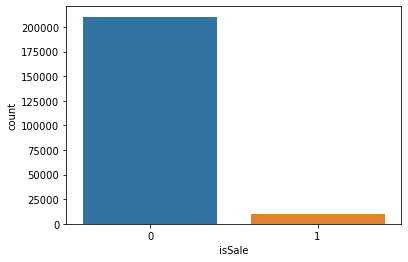

In [14]:
# visualize data
sns.countplot(x = 'isSale', data=leads_df)

In [15]:
# drop callDate and callCount
leads_df = leads_df.drop(columns=['callDate', 'callCount', 'callStartTime', 'shiftStartTime', 'DNIS', 'areaCode'])
leads_df = leads_df[['isSale', 'tenure', 'timeSinceStart', 'site', 'atOffice', 'osr3', 'state', 'dayOfWeek', 'medicareSeason', 'supervisorId', 'agentId']]

In [16]:
# one hot encoder
categorical_cols = ['agentId', 'site','supervisorId', 'state', 'dayOfWeek', 'medicareSeason', 'osr3']
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder = encoder.fit(leads_df[categorical_cols])
tmp_ohe_data = pd.DataFrame(
        encoder.transform(leads_df[categorical_cols]).toarray(),
        columns=encoder.get_feature_names(categorical_cols),
    )

cont_variable_df = leads_df.drop(columns=categorical_cols)
cont_variable_df.reset_index(drop=True, inplace=True)

clean_lead_df = cont_variable_df.join(tmp_ohe_data)
displayDataFrame(clean_lead_df)

isSale     tenure  timeSinceStart  atOffice  agentId_00A  agentId_00B  \
0            0  18.204725           13773         0          0.0          0.0   
1            0   9.000000           12094         0          0.0          0.0   
2            0   6.000000           27961         0          0.0          0.0   
3            0  14.000000           17644         0          0.0          0.0   
4            0  71.000000           30915         0          0.0          0.0   
...        ...        ...             ...       ...          ...          ...   
219995       0  13.000000           27051         0          0.0          0.0   
219996       0   2.000000            6435         0          0.0          0.0   
219997       0  12.000000           19390         0          0.0          0.0   
219998       0   8.000000           10308         0          0.0          0.0   
219999       0   4.000000           18285         0          0.0          0.0   

        agentId_00C  agentId_00D  agentId_00E  agentId_00F  ...  osr3_TVS  \
0               0.0          0.0          0.0          0.0  ...       0.0   
1               0.0          0.0          0.0          0.0  ...       0.0   
2               0.0          0.0          0.0          0.0  ...       0.0   
3               0.0          0.0          0.0          0.0  ...       0.0   
4               0.0          0.0          0.0          0.0  ...       0.0   
...             ...          ...          ...          ...  ...       ...   
219995          0.0          0.0          0.0          0.0  ...       0.0   
219996          0.0          0.0          0.0          0.0  ...       0.0   
219997          0.0          0.0          0.0          0.0  ...       0.0   
219998          0.0          0.0          0.0          0.0  ...       0.0   
219999          0.0          0.0          0.0          0.0  ...       0.0   

        osr3_UP1  osr3_UP2  osr3_US1  osr3_US2  osr3_US3  osr3_US4  osr3_US5  \
0            0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1            0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2            0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3            0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4            0.0       0.0       0.0       0.0       0.0       0.0       0.0   
...          ...       ...       ...       ...       ...       ...       ...   
219995       0.0       0.0       0.0       0.0       1.0       0.0       0.0   
219996       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
219997       0.0       0.0       0.0       1.0       0.0       0.0       0.0   
219998       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
219999       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

        osr3_WEB  osr3_Web  
0            0.0       0.0  
1            0.0       0.0  
2            0.0       0.0  
3            0.0       0.0  
4            0.0       0.0  
...          ...       ...  
219995       0.0       0.0  
219996       0.0       0.0  
219997       0.0       0.0  
219998       0.0       0.0  
219999       0.0       0.0  

[220000 rows x 1447 columns]

In [17]:
# input and outputs
X = clean_lead_df.iloc[:, 1:]
y = clean_lead_df.iloc[:, 0]
print(X)

           tenure  timeSinceStart  atOffice  agentId_00A  agentId_00B  \
0       18.204725           13773         0          0.0          0.0   
1        9.000000           12094         0          0.0          0.0   
2        6.000000           27961         0          0.0          0.0   
3       14.000000           17644         0          0.0          0.0   
4       71.000000           30915         0          0.0          0.0   
...           ...             ...       ...          ...          ...   
219995  13.000000           27051         0          0.0          0.0   
219996   2.000000            6435         0          0.0          0.0   
219997  12.000000           19390         0          0.0          0.0   
219998   8.000000           10308         0          0.0          0.0   
219999   4.000000           18285         0          0.0          0.0   

        agentId_00C  agentId_00D  agentId_00E  agentId_00F  agentId_00G  ...  \
0               0.0          0.0          0

In [18]:
# Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [19]:
# normalize inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [20]:
# model parameters
EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 0.001
INPUT_SIZE = len(X_train[0])

In [21]:
## dataloader

# train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
# test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
test_data = testData(torch.FloatTensor(X_test))

In [22]:
# initialize dataloaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [28]:
# binary classification model
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # 1073 inputs
        self.layer_1 = nn.Linear(INPUT_SIZE, 4*INPUT_SIZE) 
        self.layer_2 = nn.Linear(4*INPUT_SIZE, 4*INPUT_SIZE)
        self.layer_out = nn.Linear(4*INPUT_SIZE, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(4*INPUT_SIZE)
        self.batchnorm2 = nn.BatchNorm1d(4*INPUT_SIZE)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [24]:
# check if on gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [25]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [29]:
# initialize model and move to gpu
model = binaryClassification().to(device)
print(model)
pos_weight = torch.tensor([28])
print(pos_weight)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).cuda()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=1446, out_features=5784, bias=True)
  (layer_2): Linear(in_features=5784, out_features=1, bias=True)
)
tensor([28])


In [30]:
# train model
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 1.35813 | Acc: 61.693
Epoch 002: | Loss: 1.32916 | Acc: 71.405
Epoch 003: | Loss: 1.32235 | Acc: 72.850
Epoch 004: | Loss: 1.34014 | Acc: 73.265
Epoch 005: | Loss: 1.33294 | Acc: 74.052
Epoch 006: | Loss: 1.33468 | Acc: 74.681
Epoch 007: | Loss: 1.32896 | Acc: 73.542
Epoch 008: | Loss: 1.33054 | Acc: 74.834
Epoch 009: | Loss: 1.33230 | Acc: 75.170
Epoch 010: | Loss: 1.33131 | Acc: 75.497


In [31]:
# test model
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = y_test_pred #torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [32]:
# computing the average score (before they are rounded for the sales and the fails (nonsales))
sale_av = 0
sale_c = 0
fail_av = 0
fail_c = 0

for i in range(len(y_pred_list)):
    if y_test[i] == 0:
        fail_av += y_pred_list[i]
        fail_c += 1
    else:
        sale_av += y_pred_list[i]
        sale_c += 1
    #print(y_pred_list[i], y_test[i])
    
print(sale_av/sale_c, fail_av/fail_c)

0.6560233940160082 0.5564332642881178


In [39]:
# testing different agents
## takes a given row from the dataset and creates a dataframe with copies of that row with each of the other agents in the dataset
agents = leads_df['agentId'].unique()
row = leads_df.iloc[395].values 
tests = []
for agent in agents:
    thiso = np.append(row[:-1], [agent])
    tests.append(thiso)       

In [40]:
test_df = pd.DataFrame(tests, columns=leads_df.columns)

In [41]:
tmp_ohe_data = pd.DataFrame(
        encoder.transform(test_df[categorical_cols]).toarray(),
        columns=encoder.get_feature_names(categorical_cols),
    )

cont_variable_df = test_df.drop(columns=categorical_cols)
cont_variable_df.reset_index(drop=True, inplace=True)

clean_test_df = cont_variable_df.join(tmp_ohe_data)
displayDataFrame(clean_test_df)

isSale  tenure  timeSinceStart  atOffice  agentId_00A  agentId_00B  \
0          0    12.0           25980         0          0.0          0.0   
1          0    12.0           25980         0          0.0          0.0   
2          0    12.0           25980         0          0.0          0.0   
3          0    12.0           25980         0          0.0          0.0   
4          0    12.0           25980         0          0.0          0.0   
...      ...     ...             ...       ...          ...          ...   
1159       0    12.0           25980         0          0.0          0.0   
1160       0    12.0           25980         0          0.0          0.0   
1161       0    12.0           25980         0          0.0          0.0   
1162       0    12.0           25980         0          0.0          0.0   
1163       0    12.0           25980         0          0.0          0.0   

      agentId_00C  agentId_00D  agentId_00E  agentId_00F  ...  osr3_TVS  \
0             0.0          0.0          0.0          0.0  ...       0.0   
1             0.0          0.0          0.0          0.0  ...       0.0   
2             0.0          0.0          0.0          0.0  ...       0.0   
3             0.0          0.0          0.0          0.0  ...       0.0   
4             0.0          0.0          0.0          0.0  ...       0.0   
...           ...          ...          ...          ...  ...       ...   
1159          0.0          0.0          0.0          0.0  ...       0.0   
1160          0.0          0.0          0.0          0.0  ...       0.0   
1161          0.0          0.0          0.0          0.0  ...       0.0   
1162          0.0          0.0          0.0          0.0  ...       0.0   
1163          0.0          0.0          0.0          0.0  ...       0.0   

      osr3_UP1  osr3_UP2  osr3_US1  osr3_US2  osr3_US3  osr3_US4  osr3_US5  \
0          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
...        ...       ...       ...       ...       ...       ...       ...   
1159       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1160       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1161       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1162       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1163       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

      osr3_WEB  osr3_Web  
0          0.0       0.0  
1          0.0       0.0  
2          0.0       0.0  
3          0.0       0.0  
4          0.0       0.0  
...        ...       ...  
1159       0.0       0.0  
1160       0.0       0.0  
1161       0.0       0.0  
1162       0.0       0.0  
1163       0.0       0.0  

[1164 rows x 1447 columns]

In [42]:
# input and outputs
X = clean_test_df.iloc[:, 1:]
y = clean_test_df.iloc[:, 0]
X_test = scaler.transform(X)
test_data = testData(torch.FloatTensor(X_test))
test_agent_loader = DataLoader(dataset=test_data, batch_size=1)

# test model
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_agent_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = y_test_pred #torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

<AxesSubplot:ylabel='Count'>

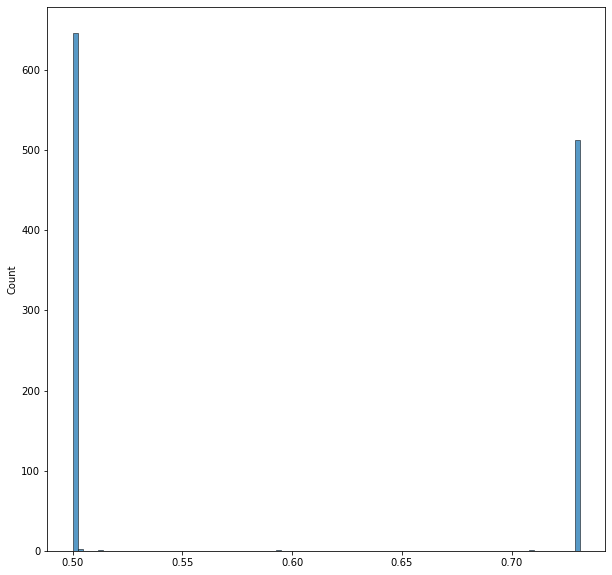

In [43]:
# histogram of the predicted scores of the agents on the same lead
plt.figure(figsize=(10,10))
sns.histplot(data=y_pred_list, bins=100)